In [1]:
import os
import random
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import transformers
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaModel
from transformers import BertTokenizer, pipeline
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import Adam
import time
import json
import spacy


import random
from collections import Counter, defaultdict
import numpy as np
from sample_few_shot import get_label_dict
from finetune_model import RobertaNER, BertNER
from eval_util import batch_span_eval
from data import *
from torch.utils.tensorboard import SummaryWriter

c:\users\athul raj nambiar\appdata\local\programs\python\python38\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.18.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [3]:
def generate_batch(batch):
    text = [F.pad(torch.tensor(x[0]), (0,max_seq_len-len(x[0])), "constant", 1) for x in batch] # batch_size * max_seq_len 
    text = pad_sequence(text, batch_first = True)
    attention_mask = [torch.cat((torch.ones_like(torch.tensor(x[0])), torch.zeros(max_seq_len-len(x[0]), dtype=torch.int64)), dim=0)
        if len(x[0]) < max_seq_len else torch.ones_like(torch.tensor(x[0]))[:max_seq_len] for x in batch]
    attention_mask = pad_sequence(attention_mask, batch_first = True)
    label = [F.pad(torch.tensor(x[1]), (0,max_seq_len-len(x[1])), "constant", -100) for x in batch]
    label = pad_sequence(label, batch_first = True)
    orig_len = [len(x[0]) for x in batch]

    return text, attention_mask, label, orig_len

In [4]:
class Args:
    def __init__(self):
        i = 0
        self.datapath = 'dataset'
        self.dataset = 'custom'
        self.train_text = f'FS_train_dataset{i}.words'
        self.train_ner = f'FS_train_dataset{i}.ner'
        self.test_text = f'FS_test_dataset{i}.words'
        self.test_ner = f'FS_test_dataset{i}.ner'
        self.model_save_name = f'FS_train_dataset{i}_finetuned_model'
        self.few_shot_sets = 1
        self.unsup_text = None
        self.unsup_ner = None
        self.base_model = 'roberta'
        self.epoch = 5
        self.train_cls_num = 4
        self.test_cls_num = 18
        self.max_seq_len = 128
        self.batch_size = 8
        self.soft_kmeans = False
        self.lr = 1e-04
        self.unsup_lr = 0.5
        self.warmup_proportion = 0.1
        self.weight_decay = 0.01
        self.use_truecase = False
        self.local_rank = None
        self.use_gpu = 'cuda'
        self.data_size = ''
        self.load_model = True
        self.reinit = False
        self.load_model_name = 'pretrained_models/lc_pretrained_190.pt'
        self.load_checkpoint = False
        self.load_dataset = False
        self.train_dataset_file = None
        self.test_dataset_file = None
        self.label2ids = None
        self.id2labels = None

args = Args()

In [5]:
label2id = {'O': 0,
 'B-Company_Name': 1,
 'I-Company_Name': 2,
 'B-Internal_Organization': 3,
 'I-Internal_Organization': 4,
 'B-Software_Name': 5,
 'I-Software_Name': 6,
 'B-Userbase_Information': 7,
 'I-Userbase_Information': 8,
 'B-Software_Purpose': 9,
 'I-Software_Purpose': 10,
 'B-Development_Scalability': 11,
 'I-Development_Scalability': 12,
 'B-Transaction_Scalability': 13,
 'I-Transaction_Scalability': 14,
 'B-Data_Scalability': 15,
 'I-Data_Scalability': 16}

In [6]:
id2label = {0: 'O',
 1: 'B-Company_Name',
 2: 'I-Company_Name',
 3: 'B-Internal_Organization',
 4: 'I-Internal_Organization',
 5: 'B-Software_Name',
 6: 'I-Software_Name',
 7: 'B-Userbase_Information',
 8: 'I-Userbase_Information',
 9: 'B-Software_Purpose',
 10: 'I-Software_Purpose',
 11: 'B-Development_Scalability',
 12: 'I-Development_Scalability',
 13: 'B-Transaction_Scalability',
 14: 'I-Transaction_Scalability',
 15: 'B-Data_Scalability',
 16: 'I-Data_Scalability'}

In [7]:
# Data preparation 
test_text = os.path.join(args.datapath, args.dataset, args.test_text)

with open(test_text, encoding='utf-8') as f:
    test_words = f.readlines()     

    
# Making dummy tags
test_ner_tags = []
for t in test_words:
    word_list = t.split()
    tags = " ".join(["O"] * len(word_list))
    tags = tags + "\n"
    test_ner_tags.append(tags)


# The tokenizer for roberta
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')    
    
# Getting the labell ids
label2ids, id2labels = [], []
processed_test_set, test_label_sentence_dicts = [], []

label2ids.append(label2id)
id2labels.append(id2label)

#Keeping track of the unprocessed data
unprocessed_test_ner_tags = test_ner_tags
unprocessed_test_words = test_words


# Processesing data to input into model
max_seq_len = args.max_seq_len
test_ner_tags, test_words, test_label_sentence_dict = process_data(test_ner_tags, test_words, tokenizer, label2id, max_seq_len,base_model=args.base_model,use_truecase=args.use_truecase)


sub_valid_ = [[test_words[i], test_ner_tags[i]] for i in range(len(test_ner_tags))] 

processed_test_set.append(sub_valid_) 


dataset_label_nums = [len(x) for x in label2ids]
test_num_data_point = sum([len(sub_valid_) for sub_valid_ in processed_test_set])

In [8]:
dataset_label_nums

[17]

In [9]:
# Importing the fine-tuned model
new_model = RobertaNER.from_pretrained('roberta-base', dataset_label_nums=dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
new_model = torch.nn.DataParallel(new_model)
i = 0
new_model.load_state_dict(torch.load(os.path.join("trained_model",f"FS_train_dataset{i}_finetuned_model_dict.pt")))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaNER: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaNER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaNER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaNER were not initialized from the model checkpoint at roberta-base and are newly initialized: ['background', 'classifier.weight', 'classifier.bias', 'classifiers.0.weight', 'classifiers.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for p

<All keys matched successfully>

In [10]:
def get_predictions(data_):
    dataset_chosen = []
    data = []
    for i,d in enumerate(data_):
        one_dataset = [generate_batch(d)]
        data.extend(one_dataset)
        dataset_chosen.extend([i for x in range(len(one_dataset))])
        
    idx = 0
    f1ss = []
    pss = []
    rss = []
    
    
    new_model.eval()
    
    for j, (text, attention_mask, cls, orig_len) in enumerate(data):
        with torch.no_grad():
            text_1, attention_mask_1, cls_1 = text.to(device), attention_mask.to(device).to(device), cls.to(device)
            loss, outputs = new_model(text_1, attention_mask=attention_mask_1, labels=cls_1, dataset = dataset_chosen[j])
        preds = [[id2label[int(x)] for j,x in enumerate(y[1:orig_len[i]-1]) if int(cls[i][j + 1]) != -100] for i,y in enumerate(outputs)]
        gold = [[id2label[int(x)] for x in y[1:orig_len[i]-1] if int(x) != -100] for i,y in enumerate(cls)]
    
    return preds, gold

In [11]:
pred, original = get_predictions(processed_test_set)

In [37]:
def find_entities(labels):
    entities = {}
    start_idx = None

    for idx, label in enumerate(labels):
        if label.startswith('B-'):
            # Found the start of an entity
            if start_idx is not None:
                # Add the previous entity to the dictionary
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
            
            start_idx = idx
        elif label.startswith('I-'):
            # Continue the current entity
            if start_idx is None:
                start_idx = idx
        else:
            # End of entity
            if start_idx is not None:
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
                start_idx = None

    # Check if there's an entity that spans till the end of the list
    if start_idx is not None:
        entity = labels[start_idx].split('-')[1]
        entities[entity] = entities.get(entity,[]) + [list(range(start_idx, len(labels)))]

    return entities

In [96]:
noun_based_enitites = ['Company_Name','Internal_Organization', 'Software_Name']

rest_entities = ['Software_Purpose','Development_Scalability','Transaction_Scalability', 'Data_Scalability', 'Userbase_Information']

In [97]:
# nlp = spacy.load('en_core_web_sm')

# # Function to retrieve graph nodes based of the entities, in the process we also use lemmatization from spaCy
# def get_graph_nodes(sentence,nlp,prediction):
#     # Using lemmatization on all the words in the sentence
#     doc = nlp(sentence)
#     lem_dict = {}
#     for token in doc:
#         lem_dict[token.text] = token.lemma_
        
#     # Retriving the indices of the predictions
#     entity_pos = find_entities(prediction)
#     node_dict = {}

#     s_tokens = sentence.split()
#     lem_keys = lem_dict.keys()
#     original_token_dict = {}
#     for e in entity_pos:
#         for idx in entity_pos[e]:
#             token = ""
#             token2 = ""
#             for i in idx:
#                 temp  = s_tokens[i]
#                 if temp in lem_keys:
#                     token = token +" "+ lem_dict[temp]
#                 else:
#                     token = token +" "+ temp
#                 # Keeping track of the the original (no lemmatization)
#                 token2 = token2 +" "+ temp
                
#             node_list = node_dict.get(e,[])
#             node_dict[e] = node_list +[token.strip()]
            
#             # Adding the the lemmatized token to a dict to retrieve the original token
#             original_token_dict[token.strip()] = token2.strip()
            
#     node_dict["original_tokens_dict"] = original_token_dict       
#     node_dict['full_sentence'] = sentence
#     node_dict['full_predictions'] = prediction
#     node_dict['all_entities'] = list(entity_pos.keys())
#     return node_dict


In [169]:
# All the following functions are used to preprocess the predicted entity so that we can lemmatize the entity
# and remove the unecessary Parts of Speech tags from the predicted entity based off the whole sentence

# Function to invert a dictionary
def invert_dict(dictionary):
    inverted_dict = {value: key for key, value in dictionary.items()}
    return inverted_dict

# Function to map the spacy token in the index range of the original string
def map_input_to_spacy_tokens(input_string, doc):
    token_mapping = {}

    for token in doc:
        start_index = token.idx
        end_index = start_index + len(token.text) - 1
        token_mapping[token.i] = (start_index, end_index)

    return invert_dict(token_mapping)

# Function to check get the indexes of a substring from the original
def find_substring_indexes(larger_string, substring):
    start = larger_string.find(substring)
    if start == -1:
        return None  # Substring not found in the larger string
    end = start + len(substring) - 1
    return start, end

# Function to check if index range overlap
def ranges_overlap(range1, range2):
    start1, end1 = range1
    start2, end2 = range2

    if start1 <= start2 <= end1 or start2 <= start1 <= end2:
        return True
    return False

def regular_to_spacy_mapping(input_string, string_tokens, doc):
    spacy_tokens = list(doc)
    token_mapping = map_input_to_spacy_tokens(input_string, doc)

    regular_to_spacy_mapping = {}
    for i, s in enumerate(string_tokens):
        for j, value in enumerate(token_mapping):
            indexes = find_substring_indexes(input_string, s)

            if ranges_overlap(value, indexes):
                temp = regular_to_spacy_mapping.get(i,[])
                regular_to_spacy_mapping[i] = temp +[j]
    return regular_to_spacy_mapping

# Function to filter out pos tags that we want to remove from out map dictionary
def filter_tokens_by_pos(pos_list, indexes, regular_to_spacy_map, pos_to_keep):
    # indexes contains the indices of all the tokens that our selected entity belongs to
    for i in indexes:
        new_mapped_indexes = []
        # We are keeping tokens from the spacy tokens when they match the pos tag we want
        for mapped_i in regular_to_spacy_map[i]:
            if pos_list[mapped_i] in pos_to_keep:
                new_mapped_indexes.append(mapped_i)
        regular_to_spacy_map[i] = new_mapped_indexes
        
    return regular_to_spacy_map

In [189]:
nlp = spacy.load('en_core_web_sm')

# POS tags we want to keep in the entites, decided based on looking at training data
pos_to_keep_noun_based = ["NOUN", "PROPN", "ADJ", "NUM", "SYM", "X", "ADP"] 
pos_to_keep_rest = ["NOUN", "PROPN", "ADJ", "NUM", "SYM", "X", "ADP", "VERB"] 


# Function to retrieve graph nodes based of the entities, in the process we also use lemmatization from spaCy
def get_graph_nodes(sentence,nlp,prediction):
    # Obtain a mapping for the string to spacy tokens
    doc = nlp(sentence)
    s_tokens = sentence.split()
    regular_to_spacy_map = regular_to_spacy_mapping(sentence, s_tokens,doc)
    
    # Using lemmatization on all the words in the sentence
    pos_list = []
    lem_list = []
    for token in doc:
        lem_list.append(token.lemma_)
        pos_list.append(token.pos_)
        
#     for i,token in enumerate(doc):
#         print(pos_list[i],token.pos_,token.text)
    
#     print(regular_to_spacy_map)
#     print(s_tokens)
        
    # Retriving the indices of the predictions
    entity_pos = find_entities(prediction)
    node_dict = {}
    original_token_dict = {}
    
    for e in entity_pos:
        for idx in entity_pos[e]:
            # Filtering out the tokens we dont need
            if e in noun_based_enitites:
                regular_to_spacy_map = filter_tokens_by_pos(pos_list, idx, regular_to_spacy_map, pos_to_keep_noun_based)
            else:
                regular_to_spacy_map = filter_tokens_by_pos(pos_list, idx, regular_to_spacy_map, pos_to_keep_rest)

            # Placing the entity into one string    
            original_entity_string = ""
            lemmatized_entity_string = ""
            
            for i in idx:
                original_entity_string  = original_entity_string+ " "+ s_tokens[i]
                
                for mapped_i in regular_to_spacy_map[i]:
                    lemmatized_entity_string = lemmatized_entity_string + " "+ lem_list[mapped_i]
            
            if lemmatized_entity_string.strip():
                node_list = node_dict.get(e,[])
                node_dict[e] = node_list +[lemmatized_entity_string.strip()]

                # Adding the the lemmatized token to a dict to retrieve the original token
                original_token_dict[original_entity_string.strip()] = lemmatized_entity_string.strip()
            
    node_dict["original_tokens_dict"] = original_token_dict       
    node_dict['full_sentence'] = sentence
    node_dict['full_predictions'] = prediction
    node_dict['all_entities'] = list(entity_pos.keys())
    return node_dict

In [190]:
all_inputs = []
for i, s in enumerate(unprocessed_test_words):
    result = get_graph_nodes(s,nlp,pred[i])
    all_inputs.append(result)
    

PROPN PROPN ALLDATA
VERB VERB provides
ADJ ADJ innovative
NOUN NOUN software
NOUN NOUN solutions
PRON PRON that
VERB VERB connect
ADJ ADJ automotive
NOUN NOUN repair
NOUN NOUN technicians
ADP ADP with
DET DET the
ADJ ADJ diagnostic
CCONJ CCONJ and
NOUN NOUN repair
NOUN NOUN information
PRON PRON they
VERB VERB need
ADP ADP from
ADJ ADJ original
NOUN NOUN equipment
NOUN NOUN manufacturers
PUNCT PUNCT (
PROPN PROPN OEMs
PUNCT PUNCT )
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [8], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22, 23, 24, 25]}
['ALLDATA', 'provides', 'innovative', 'software', 'solutions', 'that', 'connect', 'automotive', 'repair', 'technicians', 'with', 'the', 'diagnostic', 'and', 'repair', 'information', 'they', 'need', 'from', 'original', 'equipment', 'manufacturers', '(OEMs).']
PROPN PROPN Fabio
PROPN PROPN Bacchilega
VERB VERB over

PROPN PROPN AWS
PROPN PROPN Marketplace
AUX AUX is
DET DET a
VERB VERB curated
ADJ ADJ digital
NOUN NOUN catalog
SCONJ SCONJ that
NOUN NOUN customers
AUX AUX can
VERB VERB use
PART PART to
VERB VERB find
PUNCT PUNCT ,
VERB VERB buy
PUNCT PUNCT ,
VERB VERB deploy
PUNCT PUNCT ,
CCONJ CCONJ and
VERB VERB manage
ADJ ADJ third
PUNCT PUNCT -
NOUN NOUN party
NOUN NOUN software
PUNCT PUNCT ,
NOUN NOUN data
PUNCT PUNCT ,
CCONJ CCONJ and
NOUN NOUN services
PART PART to
VERB VERB build
NOUN NOUN solutions
CCONJ CCONJ and
VERB VERB run
PRON PRON their
NOUN NOUN businesses
PUNCT PUNCT .
PROPN PROPN AWS
PROPN PROPN Marketplace
VERB VERB includes
NOUN NOUN thousands
ADP ADP of
NOUN NOUN software
NOUN NOUN listings
ADP ADP from
ADJ ADJ popular
NOUN NOUN categories
ADJ ADJ such
ADP ADP as
NOUN NOUN security
PUNCT PUNCT ,
NOUN NOUN business
NOUN NOUN applications
PUNCT PUNCT ,
NOUN NOUN machine
NOUN NOUN learning
PUNCT PUNCT ,
CCONJ CCONJ and
NOUN NOUN data
NOUN NOUN products
ADP ADP across
ADJ ADJ spec

PROPN PROPN Wondershare
AUX AUX is
DET DET a
NOUN NOUN provider
ADP ADP of
NOUN NOUN PC
CCONJ CCONJ and
ADJ ADJ mobile
NOUN NOUN applications
ADP ADP in
DET DET the
NOUN NOUN areas
ADP ADP of
NOUN NOUN creativity
CCONJ CCONJ &
PROPN PROPN multi
NOUN NOUN -
ADJ ADJ media
PUNCT PUNCT ,
NOUN NOUN document
NOUN NOUN management
PUNCT PUNCT ,
CCONJ CCONJ and
NOUN NOUN utilities
ADP ADP for
ADJ ADJ worldwide
NOUN NOUN users
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [0], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [4], 13: [13], 14: [14], 15: [15, 16, 17, 18], 16: [19], 17: [20, 21], 18: [6], 19: [23], 20: [24], 21: [25], 22: [26, 27]}
['Wondershare', 'is', 'a', 'provider', 'of', 'PC', 'and', 'mobile', 'applications', 'in', 'the', 'areas', 'of', 'creativity', '&', 'multi-media,', 'document', 'management,', 'and', 'utilities', 'for', 'worldwide', 'users.']
PROPN PROPN BitDefender
PUNCT PUNCT ,
DET DET an
NOUN NOUN award
PUNCT PUNCT -
VERB VERB winning
N

PRON PRON We
VERB VERB call
PRON PRON our
ADJ ADJ entire
NOUN NOUN portfolio
ADP ADP of
NOUN NOUN products
CCONJ CCONJ and
NOUN NOUN services
PROPN PROPN Customer
NUM NUM 360
PUNCT PUNCT .
PRON PRON It
VERB VERB ’s
SCONJ SCONJ how
PRON PRON you
AUX AUX can
VERB VERB unite
PRON PRON your
NOUN NOUN company
PUNCT PUNCT —
PRON PRON your
NOUN NOUN sales
PUNCT PUNCT ,
NOUN NOUN service
PUNCT PUNCT ,
NOUN NOUN marketing
PUNCT PUNCT ,
NOUN NOUN commerce
PUNCT PUNCT ,
CCONJ CCONJ and
PROPN PROPN IT
NOUN NOUN teams
PUNCT PUNCT —
ADP ADP around
DET DET a
ADJ ADJ single
VERB VERB shared
NOUN NOUN view
ADP ADP of
PRON PRON your
NOUN NOUN customers
VERB VERB using
PROPN PROPN AI
CCONJ CCONJ and
ADJ ADJ real
PUNCT PUNCT -
NOUN NOUN time
PUNCT PUNCT ,
ADJ ADJ actionable
NOUN NOUN data
PART PART to
VERB VERB help
VERB VERB wow
PRON PRON your
NOUN NOUN customers
DET DET every
NOUN NOUN time
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [

DET DET A
NOUN NOUN security
NOUN NOUN master
AUX AUX is
DET DET a
ADV ADV highly
VERB VERB trusted
NOUN NOUN user
PRON PRON who
VERB VERB has
ADJ ADJ complete
NOUN NOUN access
ADP ADP to
DET DET all
DET DET the
PROPN PROPN ADP
NOUN NOUN services
PRON PRON your
NOUN NOUN organization
VERB VERB uses
PUNCT PUNCT .
NOUN NOUN Security
NOUN NOUN masters
VERB VERB requires
NOUN NOUN administrator
NOUN NOUN access
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [2], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19, 20], 20: [21], 21: [22], 22: [23], 23: [24], 24: [25, 26]}
['A', 'security', 'master', 'is', 'a', 'highly', 'trusted', 'user', 'who', 'has', 'complete', 'access', 'to', 'all', 'the', 'ADP', 'services', 'your', 'organization', 'uses.', 'Security', 'masters', 'requires', 'administrator', 'access.']
PROPN PROPN Agile
PART PART ’s
NOUN NOUN roots
ADP ADP in
NOUN NOUN software
ADV AD

PRON PRON They
ADV ADV then
VERB VERB worked
ADP ADP in
NOUN NOUN sprints
PART PART to
VERB VERB identify
NOUN NOUN priority
NOUN NOUN data
VERB VERB based
ADP ADP on
DET DET the
NOUN NOUN value
PRON PRON they
AUX AUX could
VERB VERB deliver
PUNCT PUNCT ,
VERB VERB checking
ADP ADP in
ADP ADP with
DET DET the
PROPN PROPN CEO
CCONJ CCONJ and
ADJ ADJ senior
NOUN NOUN leadership
NOUN NOUN team
DET DET every
ADJ ADJ few
NOUN NOUN weeks
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [1], 12: [12], 13: [13], 14: [14], 15: [15, 16], 16: [17], 17: [3], 18: [19], 19: [1], 20: [21], 21: [22], 22: [23], 23: [24], 24: [25], 25: [26], 26: [27], 27: [28, 29]}
['They', 'then', 'worked', 'in', 'sprints', 'to', 'identify', 'priority', 'data', 'based', 'on', 'the', 'value', 'they', 'could', 'deliver,', 'checking', 'in', 'with', 'the', 'CEO', 'and', 'senior', 'leadership', 'team', 'every', 'few', 'weeks.']
PUNCT PUNCT “
DET DET T

DET DET The
NOUN NOUN company
AUX AUX can
ADV ADV now
VERB VERB show
PRON PRON its
ADJ ADJ corporate
NOUN NOUN customers
SCONJ SCONJ when
CCONJ CCONJ and
SCONJ SCONJ where
PRON PRON their
NOUN NOUN employees
VERB VERB log
ADP ADP in
ADP ADP to
PROPN PROPN Anaplan
PUNCT PUNCT ,
CCONJ CCONJ and
SCONJ SCONJ how
ADV ADV long
PRON PRON they
VERB VERB used
PRON PRON it
PUNCT PUNCT ,
ADP ADP on
DET DET a
NOUN NOUN dashboard
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [7], 16: [16, 17], 17: [9], 18: [4], 19: [20], 20: [21], 21: [22], 22: [23, 24], 23: [20], 24: [1], 25: [27, 28]}
['The', 'company', 'can', 'now', 'show', 'its', 'corporate', 'customers', 'when', 'and', 'where', 'their', 'employees', 'log', 'in', 'to', 'Anaplan,', 'and', 'how', 'long', 'they', 'used', 'it,', 'on', 'a', 'dashboard.']
ADP ADP In
ADJ ADJ general
PUNCT PUNCT ,
ADJ ADJ most
PROPN PROPN OpenSearch
NOUN

ADV ADV Furthermore
PUNCT PUNCT ,
PROPN PROPN Grammarly
VERB VERB has
ADJ ADJ more
ADP ADP than
NUM NUM 30
NUM NUM million
ADJ ADJ daily
ADJ ADJ active
NOUN NOUN users
ADP ADP as
ADP ADP of
NUM NUM 2023
PUNCT PUNCT ,
CCONJ CCONJ and
PRON PRON it
VERB VERB generated
ADJ ADJ more
ADP ADP than
NUM NUM 8.8
NUM NUM million
PROPN PROPN US
NOUN NOUN dollars
ADP ADP in
DET DET the
NOUN NOUN year
NUM NUM 2022
PUNCT PUNCT .
SPACE SPACE 

{0: [0, 1], 1: [2], 2: [3], 3: [0], 4: [5], 5: [6], 6: [7], 7: [8], 8: [9], 9: [10], 10: [3], 11: [12], 12: [13, 14], 13: [15], 14: [16], 15: [17], 16: [0], 17: [5], 18: [20], 19: [7], 20: [22], 21: [23], 22: [24], 23: [0], 24: [26], 25: [27, 28]}
['Furthermore,', 'Grammarly', 'has', 'more', 'than', '30', 'million', 'daily', 'active', 'users', 'as', 'of', '2023,', 'and', 'it', 'generated', 'more', 'than', '8.8', 'million', 'US', 'dollars', 'in', 'the', 'year', '2022.']
ADP ADP In
PROPN PROPN December
NUM NUM 2022
PUNCT PUNCT ,
PROPN PROPN Grammarly
VERB VERB rec

SCONJ SCONJ When
NOUN NOUN data
NOUN NOUN volume
ADV ADV rapidly
VERB VERB grows
PUNCT PUNCT ,
PROPN PROPN Hadoop
ADV ADV quickly
VERB VERB scales
PART PART to
VERB VERB accommodate
DET DET the
NOUN NOUN demand
ADP ADP via
PROPN PROPN Hadoop
PROPN PROPN Distributed
PROPN PROPN File
PROPN PROPN System
PUNCT PUNCT (
PROPN PROPN HDFS
PUNCT PUNCT )
PUNCT PUNCT .
ADP ADP In
NOUN NOUN turn
PUNCT PUNCT ,
PROPN PROPN Spark
VERB VERB relies
ADP ADP on
DET DET the
NOUN NOUN fault
ADJ ADJ tolerant
NOUN NOUN HDFS
ADP ADP for
ADJ ADJ large
NOUN NOUN volumes
ADP ADP of
NOUN NOUN data
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4, 5], 5: [6], 6: [7], 7: [8], 8: [9], 9: [10], 10: [11], 11: [12], 12: [13], 13: [6], 14: [15], 15: [16], 16: [17], 17: [18, 19, 20, 21], 18: [22], 19: [23, 24], 20: [25], 21: [26], 22: [27], 23: [11], 24: [29], 25: [30], 26: [19], 27: [32], 28: [33], 29: [34], 30: [35], 31: [36, 37]}
['When', 'data', 'volume', 'rapidly', 'grows,', 'Hadoop', 'quickly', 's

ADJ ADJ Similar
NOUN NOUN scalability
AUX AUX is
VERB VERB observed
ADP ADP in
DET DET the
ADJ ADJ sequential
NOUN NOUN read
CCONJ CCONJ and
VERB VERB write
NOUN NOUN workloads
PUNCT PUNCT .
VERB VERB Note
SCONJ SCONJ that
DET DET the
PROPN PROPN Maximum
PROPN PROPN Transfer
PROPN PROPN Unit
PUNCT PUNCT (
PROPN PROPN MTU
PUNCT PUNCT )
AUX AUX was
VERB VERB set
ADP ADP as
NUM NUM 9000
ADP ADP to
DET DET the
PROPN PROPN Virtual
PROPN PROPN SAN
NOUN NOUN network
NOUN NOUN interfaces
PART PART to
VERB VERB get
ADJ ADJ maximum
NOUN NOUN performance
ADP ADP for
DET DET the
NUM NUM two
NOUN NOUN disk
NOUN NOUN group
NOUN NOUN configuration
ADP ADP for
DET DET the
PROPN PROPN All
PROPN PROPN Read
NOUN NOUN workload
PUNCT PUNCT .
PRON PRON This
AUX AUX is
ADV ADV mainly
PART PART to
VERB VERB reduce
DET DET the
NOUN NOUN CPU
NOUN NOUN utilization
VERB VERB consumed
ADP ADP by
DET DET the
PROPN PROPN vSphere
NOUN NOUN network
NOUN NOUN stack
ADP ADP at
ADJ ADJ such
ADJ ADJ high
NOUN NOUN loads
P

PRON PRON It
VERB VERB automates
ADJ ADJ most
ADP ADP of
DET DET the
ADJ ADJ common
ADJ ADJ administrative
NOUN NOUN tasks
VERB VERB associated
ADP ADP with
NOUN NOUN provisioning
PUNCT PUNCT ,
NOUN NOUN configuring
PUNCT PUNCT ,
NOUN NOUN monitoring
PUNCT PUNCT ,
VERB VERB backing
ADP ADP up
PUNCT PUNCT ,
CCONJ CCONJ and
VERB VERB securing
DET DET a
NOUN NOUN data
NOUN NOUN warehouse
PUNCT PUNCT ,
VERB VERB making
PRON PRON it
ADJ ADJ easy
CCONJ CCONJ and
ADJ ADJ inexpensive
PART PART to
VERB VERB manage
CCONJ CCONJ and
VERB VERB maintain
PUNCT PUNCT .
DET DET This
NOUN NOUN automation
VERB VERB enables
PRON PRON you
PART PART to
VERB VERB build
ADJ ADJ petabyte
PUNCT PUNCT -
NOUN NOUN scale
NOUN NOUN data
NOUN NOUN warehouses
ADP ADP in
NOUN NOUN minutes
ADV ADV instead
ADP ADP of
NOUN NOUN weeks
CCONJ CCONJ or
NOUN NOUN months
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10, 11], 11: [12, 13], 12: [14, 15], 13: [16

DET DET The
NOUN NOUN term
PUNCT PUNCT "
NOUN NOUN security
NOUN NOUN assessment
PUNCT PUNCT "
VERB VERB refers
ADP ADP to
DET DET all
NOUN NOUN activity
VERB VERB engaged
ADP ADP in
ADP ADP for
DET DET the
NOUN NOUN purposes
ADP ADP of
VERB VERB determining
DET DET the
NOUN NOUN efficacy
CCONJ CCONJ or
NOUN NOUN existence
ADP ADP of
NOUN NOUN security
NOUN NOUN controls
ADP ADP amongst
PRON PRON your
NOUN NOUN AWS
NOUN NOUN assets
PUNCT PUNCT ,
ADV ADV e.g.
PUNCT PUNCT ,
NOUN NOUN port
PUNCT PUNCT -
NOUN NOUN scanning
PUNCT PUNCT ,
NOUN NOUN vulnerability
NOUN NOUN scanning
SYM SYM /
NOUN NOUN checks
PUNCT PUNCT ,
NOUN NOUN penetration
NOUN NOUN testing
PUNCT PUNCT ,
NOUN NOUN exploitation
PUNCT PUNCT ,
NOUN NOUN web
NOUN NOUN application
NOUN NOUN scanning
PUNCT PUNCT ,
ADV ADV as
ADV ADV well
ADP ADP as
DET DET any
NOUN NOUN injection
PUNCT PUNCT ,
NOUN NOUN forgery
PUNCT PUNCT ,
CCONJ CCONJ or
VERB VERB fuzzing
NOUN NOUN activity
PUNCT PUNCT ,
CCONJ CCONJ either
VERB VERB performed

PRON PRON Our
ADJ ADJ dedicated
NOUN NOUN security
NOUN NOUN team
VERB VERB includes
PRON PRON some
ADP ADP of
DET DET the
NOUN NOUN world
PART PART 's
ADJ ADJ foremost
NOUN NOUN experts
ADP ADP in
NOUN NOUN information
NOUN NOUN security
PUNCT PUNCT ,
NOUN NOUN application
NOUN NOUN security
PUNCT PUNCT ,
NOUN NOUN cryptography
PUNCT PUNCT ,
CCONJ CCONJ and
NOUN NOUN network
NOUN NOUN security
PUNCT PUNCT .
DET DET This
NOUN NOUN team
VERB VERB maintains
PRON PRON our
NOUN NOUN defense
NOUN NOUN systems
PUNCT PUNCT ,
VERB VERB develops
NOUN NOUN security
NOUN NOUN review
NOUN NOUN processes
PUNCT PUNCT ,
VERB VERB builds
NOUN NOUN security
NOUN NOUN infrastructure
PUNCT PUNCT ,
CCONJ CCONJ and
VERB VERB implements
PRON PRON our
NOUN NOUN security
NOUN NOUN policies
PUNCT PUNCT .
DET DET The
NOUN NOUN team
ADV ADV actively
VERB VERB scans
ADP ADP for
NOUN NOUN security
NOUN NOUN threats
VERB VERB using
ADJ ADJ commercial
CCONJ CCONJ and
NOUN NOUN custom
NOUN NOUN tools
PUNCT PUNCT .
DE

NOUN NOUN Network
NOUN NOUN automation
ADV ADV substantially
VERB VERB increases
NOUN NOUN network
NOUN NOUN efficiency
PART PART to
VERB VERB lower
DET DET the
NOUN NOUN cost
ADP ADP per
NOUN NOUN bit
CCONJ CCONJ and
VERB VERB maximize
NOUN NOUN profit
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [1], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14, 15]}
['Network', 'automation', 'substantially', 'increases', 'network', 'efficiency', 'to', 'lower', 'the', 'cost', 'per', 'bit', 'and', 'maximize', 'profit.']
SCONJ SCONJ While
ADJ ADJ hyper
PUNCT PUNCT -
NOUN NOUN scale
NOUN NOUN cloud
NOUN NOUN operators
VERB VERB drove
ADJ ADJ much
ADP ADP of
DET DET the
ADJ ADJ new
NOUN NOUN technologies
CCONJ CCONJ and
NOUN NOUN systems
PRON PRON that
PRON PRON they
VERB VERB used
PART PART to
VERB VERB build
PRON PRON their
NOUN NOUN infrastructure
PUNCT PUNCT ,
ADJ ADJ most
NOUN NOUN enterprises
AUX AUX do
PART PART not
VERB VERB have
DET D

DET DET The
NOUN NOUN software
NOUN NOUN development
NOUN NOUN lifecycle
PUNCT PUNCT (
PROPN PROPN SDLC
PUNCT PUNCT )
VERB VERB outlines
ADJ ADJ several
NOUN NOUN tasks
VERB VERB required
PART PART to
VERB VERB build
DET DET a
NOUN NOUN software
NOUN NOUN application
PUNCT PUNCT .
DET DET The
NOUN NOUN development
NOUN NOUN process
VERB VERB goes
ADP ADP through
ADJ ADJ several
NOUN NOUN stages
SCONJ SCONJ as
NOUN NOUN developers
VERB VERB add
ADJ ADJ new
NOUN NOUN features
CCONJ CCONJ and
VERB VERB fix
NOUN NOUN bugs
ADP ADP in
DET DET the
NOUN NOUN software
PUNCT PUNCT .
SPACE SPACE 

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4, 5, 6], 5: [7], 6: [8], 7: [9], 8: [10], 9: [11], 10: [12], 11: [1], 12: [1], 13: [15, 16], 14: [0], 15: [2], 16: [19], 17: [20], 18: [21], 19: [8], 20: [23], 21: [9], 22: [25], 23: [26], 24: [27], 25: [28], 26: [29], 27: [30], 28: [31], 29: [7], 30: [33], 31: [34, 35]}
['The', 'software', 'development', 'lifecycle', '(SDLC)', 'outlines', 'several', 'tasks', 'requi

In [191]:
all_inputs

[{'Company_Name': ['ALLDATA'],
  'Software_Purpose': ['connect'],
  'Internal_Organization': ['automotive repair technician'],
  'original_tokens_dict': {'ALLDATA provides': 'ALLDATA',
   'connect': 'connect',
   'automotive repair technicians': 'automotive repair technician'},
  'full_sentence': 'ALLDATA provides innovative software solutions that connect automotive repair technicians with the diagnostic and repair information they need from original equipment manufacturers (OEMs).\n',
  'full_predictions': ['B-Company_Name',
   'I-Company_Name',
   'O',
   'O',
   'O',
   'O',
   'B-Software_Purpose',
   'B-Internal_Organization',
   'I-Internal_Organization',
   'I-Internal_Organization',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O'],
  'all_entities': ['Company_Name',
   'Software_Purpose',
   'Internal_Organization']},
 {'Company_Name': ['Bruker Biospin'],
  'Data_Scalability': ['database'],
  'Userbase_Information': ['cust

In [192]:
for a in all_inputs:
    for i in rest_entities:
        if i in a:
            print(i,a[i])
    for i in noun_based_enitites:
        if i in a:
            print(i,a[i])

Software_Purpose ['connect']
Company_Name ['ALLDATA']
Internal_Organization ['automotive repair technician']
Data_Scalability ['database']
Userbase_Information ['customer engagement']
Company_Name ['Bruker Biospin']
Development_Scalability ['marketing automation software']
Company_Name ['Act on', 'BinMaster with']
Development_Scalability ['automate more']
Transaction_Scalability ['scale']
Software_Name ['IBM Robotic Process Automation']
Data_Scalability ['datum privacy']
Userbase_Information ['user anonymity']
Company_Name ['Act On']
Internal_Organization ['marketer', 'marketer']
Software_Name ['Apple Mail Privacy Protection MPP', 'Apple']
Software_Purpose ['unite']
Internal_Organization ['human resource']
Software_Name ['cloud human capital management HCM solution']
Software_Purpose ['provide']
Company_Name ['ADP']
Internal_Organization ['payroll team']
Software_Name ['payroll software']
Software_Purpose ['store datum such']
Data_Scalability ['datum analysis']
Userbase_Information ['u

In [197]:
# Calculating the frequency of Software_Name entities and Company_Name entities
company_frequency = {}
software_frequency = {}

def check_frequency(check_string, data, dictionary):
    if check_string in data['all_entities']:
        
        for i in data[check_string]:
            keys = list(dictionary.keys())
            
            if i in keys:
                dictionary[i] += 1
            else: 
                # Check if the string is equvialent to any of the keys, then we assume it is the same entity
                not_found= True
                for k in keys:
                    if k == i:
                        no_overlap = True
                        if len(k)>= len(i):
                            dictionary[i] = dictionary[k] + 1
                            del dictionary[k]
                        else:
                            dictionary[k] += 1
                if not_found:
                    dictionary[i] = 1
                    
    return dictionary

for d in all_inputs:
    company_frequency = check_frequency('Company_Name', d, company_frequency)
    software_frequency = check_frequency('Software_Name', d, software_frequency)

In [198]:
company_frequency

{'ALLDATA': 1,
 'Bruker Biospin': 1,
 'Act on': 1,
 'BinMaster with': 1,
 'Act On': 1,
 'ADP': 2,
 'Amadeus': 1,
 'Atlassian': 3,
 'Atlassian to': 1,
 'Aurea partner': 1,
 'Software AG': 1,
 'Wondershare': 1,
 'BitDefender': 1,
 'Adobe SPLC': 1,
 'Adobe': 1,
 'Intel': 1,
 'VMware': 1,
 'Dell': 1,
 'Thomson Reuters': 1,
 'Purple Technology': 1,
 'Lefouet': 2,
 'Anaplan': 2,
 'SAP': 1,
 'Oracle': 1,
 'Avangate': 1,
 'Amazon': 1,
 'Scalr': 1,
 'AWS': 1,
 'SLSA': 1,
 'NIST ssdf': 1,
 'AHIMA': 1}

In [199]:
software_frequency

{'IBM Robotic Process Automation': 1,
 'Apple Mail Privacy Protection MPP': 1,
 'Apple': 1,
 'cloud human capital management HCM solution': 1,
 'payroll software': 2,
 'GlobalView HCM': 1,
 'ADP': 1,
 'HCM solution': 1,
 'Streamline Payroll': 1,
 'AWS Marketplace': 2,
 'Apptio Cloudability': 1,
 'Cloudability': 1,
 'ApptioOne demand': 2,
 'ApptioOne product': 1,
 'Altéa Customer Management System': 1,
 'Stripe': 1,
 'Insight': 1,
 'security': 1,
 'Druva': 1,
 'Druva solution': 1,
 'Druva cloud native SaaS': 1,
 'AWS': 1,
 'Whirlpool': 1,
 'Google Workspace': 2,
 'Google Drive': 1,
 'Apple Mac machine': 1,
 'KnowBe4': 1,
 'Salesforce customer relationship management CRM': 1,
 'Customer 360': 1,
 'on premise software': 1,
 'Adobe product': 2,
 'Adobe Common Controls Framework': 1,
 'ADP service': 1,
 'Jira Align': 2,
 'Portfolio Manager': 1,
 'Dagger': 2,
 'multicloud analytic solution': 1,
 'multicloud': 1,
 'Kubernetes': 1,
 'Kubeapps': 2,
 'Kubernetes cluster': 1,
 'App Launchpad': 1,

# Visualization of Knowledge Graph

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

In [30]:
labels_to_colours = {'Transaction_Scalability': '#64BBE2',
                      'Data_Scalability': '#64BBE2',
                      'Development_Scalability': '#64BBE2',
                      'Software_Purpose': '#F5AF58',
                      'Userbase_Information': '#F5AF58',
                      'Internal_Organization': '#F5AF58',
                      'Software_Name': '#2F5B7C',
                      'Company_Name': '#2F5B7C',
                      'Company': '#A20025',
                      'Software': '#A20025'}

In [39]:
labels = ['Transaction_Scalability',
                      'Data_Scalability',
                      'Development_Scalability',
                      'Software_Purpose',
                      'Userbase_Information',
                      'Internal_Organization',
                      'Software_Name',
                      'Company_Name',
                      'Company',
                      'Software']

In [57]:
# Retrieves the edges for all the "Is_A" relationships
def connect_is_a_edged(input_information, check_string, edge_labels, edges):
    
    # Checking if the entities exist
    if check_string in input_information['all_entities']:
        
        modified_string = check_string.replace("_Name", "")
        # Adding all the Is_A edges
        for i in input_information[check_string]:
            edges.append([i,modified_string])
            edge_labels[(i,modified_string)] = "Is_A"
    
    return edge_labels, edges
            
        
    

In [58]:
def has_scalability_characteristics_from(input_information, check_string, edge_labels, edges):
    # Checking if the entities exist
    if check_string in input_information['all_entities']:
        
        edge_label = "Has_" + check_string + "_Characteristics_From"
        # Adding all the Is_A edges
        for i in input_information[check_string]:
            
            software_name_node = input_information['Software_Name'][0]
            
            edges.append([i,i])
            edge_labels[(i,i)] = edge_label
    return edge_labels, edges
    

In [ ]:
# Intializing the graph
G = nx.DiGraph()

In [62]:
# Constructing the graph
nodes = []
nodes.append(('Software',{"color":labels_to_colours['Software']}))
nodes.append(('Company',{"color":labels_to_colours['Company']}))

edges = []
edge_labels = {}
count = 0
for d in all_inputs:
    
    # adding all the nodes
    # iterating through all entities
    for e in d['all_entities']:
        
        # all the elements of this entity type
        for i in d[e]:
            # adding to the list of nodes
            nodes.append((i,{"color":labels_to_colours[e]}))
    
    # Placing the "Is_A" edges for Software_Name and Company_Name
    edge_labels, edges = connect_is_a_edged(d, "Software_Name", edge_labels, edges)
    edge_labels, edges = connect_is_a_edged(d, "Company_Name", edge_labels, edges)
    
    # Placing the scalability charectisitics edge labels
    print(d)
    if 'Data_Scalability' in d:
        edge_labels, edges = has_scalability_characteristics_from(d, "Data_Scalability", edge_labels, edges)
    

# Add nodes to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)
    

{'Company_Name': ['ALLDATA provide'], 'Software_Purpose': ['connect'], 'Internal_Organization': ['automotive repair technician'], 'original_tokens_dict': {'ALLDATA provide': 'ALLDATA provides', 'connect': 'connect', 'automotive repair technician': 'automotive repair technicians'}, 'full_sentence': 'ALLDATA provides innovative software solutions that connect automotive repair technicians with the diagnostic and repair information they need from original equipment manufacturers (OEMs).\n', 'full_predictions': ['B-Company_Name', 'I-Company_Name', 'O', 'O', 'O', 'O', 'B-Software_Purpose', 'B-Internal_Organization', 'I-Internal_Organization', 'I-Internal_Organization', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'all_entities': ['Company_Name', 'Software_Purpose', 'Internal_Organization']}
{'Company_Name': ['Bruker Biospin’s'], 'Data_Scalability': ['database'], 'Userbase_Information': ['customer engagement.'], 'original_tokens_dict': {'Bruker Biospin’s': 'Bruker Biospi

KeyError: 'Software_Name'

In [45]:
edge_labels

{('ALLDATA provide', 'Company'): 'Is_A',
 ('Bruker Biospin’s', 'Company'): 'Is_A',
 ('Act-On’s', 'Company'): 'Is_A',
 ('BinMaster with', 'Company'): 'Is_A',
 ('IBM Robotic Process Automation', 'Software'): 'Is_A',
 ('Apple Mail Privacy Protection (MPP)', 'Software'): 'Is_A',
 ('Apple’s', 'Software'): 'Is_A',
 ('cloud-based human capital management (HCM) solution', 'Software'): 'Is_A'}

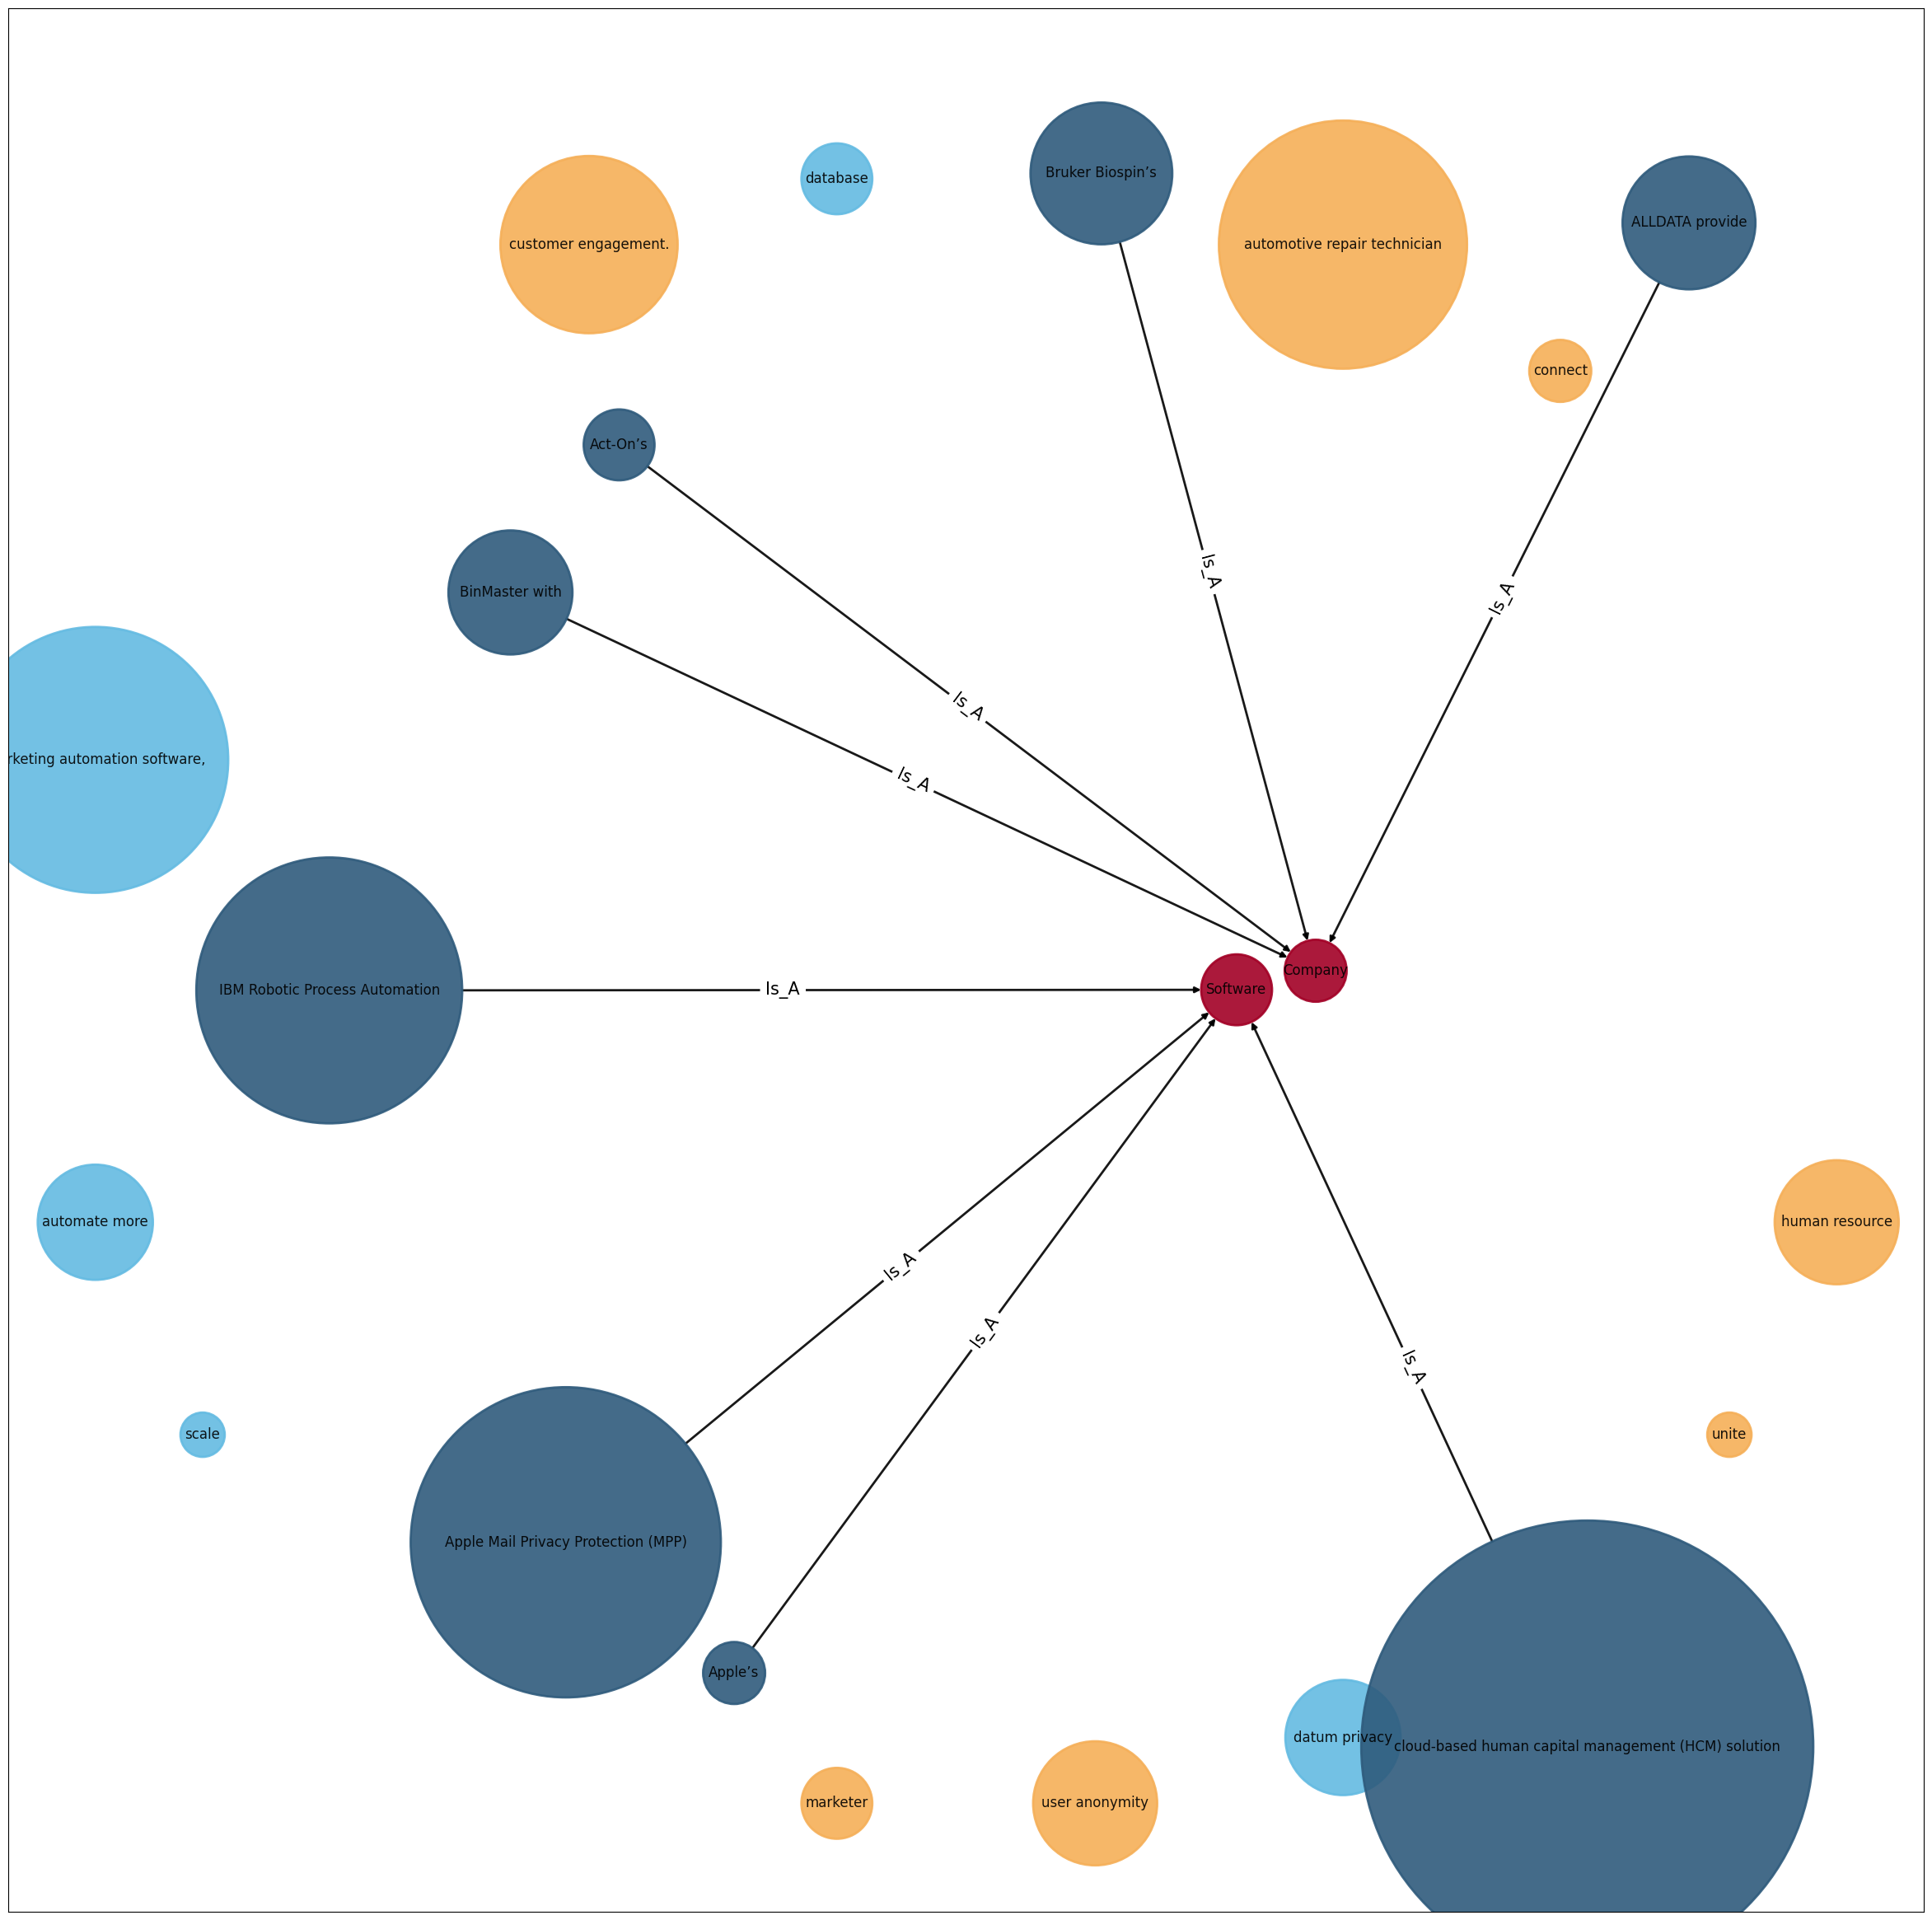

In [56]:
# Compute the positions of nodes using the Kamada-Kawai layout algorithm
positions = nx.kamada_kawai_layout(G)

# Extract the node information from the graph
nodes = list(G.nodes(data=True))

node_colors = [b['color'] for (a,b) in nodes]
labels = {node[0]: node[1].get('label', str(node[0])) for node in nodes}
node_sizes = [len(label) ** 2 * 60 for label in labels.values()]

# Plot the graph
plt.figure(figsize=(30, 30))
nx.draw_networkx(
    G,
    node_color=node_colors,
    pos=positions,
    labels=labels,
    node_size=node_sizes,
    edge_color='black', width=2, linewidths=2, alpha=0.9, font_size=12
)

nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, font_size=15)

# Display the plot
plt.show()